**SARSA and Q-Learning**

In this example, we are going to compare two algorithms that work model-free for control: SARSA and Q-learning. We will use the next MDP:

![alt text](two_state_mdp.png "Title")

Let us start with the imports. We use numpy, tabulate and matplotlib in this exercise.

In [1]:
import numpy as np
from tabulate import tabulate
import matplotlib.pyplot as plt
%matplotlib inline

The next thing we do is to seed the random number generator.This is done to ensure that the results are reproducible.At this point, this is not strictly necessary, but it is good practice to do so (and when working with Deep Reinforcement Learning, it is absolutely necessary).

In [2]:
rng = np.random.default_rng(1234)

Now, let us define the parameters of the problem, the optimal policy (which we know beforehand), the exact optimal value using the Bellman linear equations, and a `step` method to simulate the model-free MDP.

In [3]:
n_states = 2
n_actions = 2

P = np.array([[0.8, 0.2], [0.2, 0.8], [0.3, 0.7], [0.9, 0.1]])
R = np.array([[-1], [0.6], [0.5], [-0.9]])
gamma = 0.9

# Now, define the optimal policy
pi = np.zeros((2, 4))
pi[0, 1] = 1
pi[1, 2] = 1

# Compute exact values using Bellman matrix equations
q_pi_exact = np.linalg.inv(np.eye(P.shape[0]) - gamma * P @ pi) @ R

def step(state, action):  # To simulate a model-free approach: the agent does not know R and P!
  reward = R[state * n_actions + action]
  next_state = rng.choice(np.arange(n_states), p=P[state * n_actions + action])
  return next_state, reward

Now, we implement SARSA and Q-Learning following the explanation contained in the slides. We will use the $\epsilon$-greedy policy, with $\epsilon=0.1$. Note how both methods converge very close to the optimal solution, although Q-Learning does it faster and closer.

Obtaining SARSA control...
Obtaining Q-Learning control...
Optimal policy (theory)
╒═══╤═══╤═══╤═══╕
│ 0 │ 1 │ 0 │ 0 │
├───┼───┼───┼───┤
│ 0 │ 0 │ 1 │ 0 │
╘═══╧═══╧═══╧═══╛
Optimal policy (SARSA)
╒═══╤═══╤═══╤═══╕
│ 0 │ 1 │ 0 │ 0 │
├───┼───┼───┼───┤
│ 0 │ 0 │ 1 │ 0 │
╘═══╧═══╧═══╧═══╛
Optimal policy (Q-learning)
╒═══╤═══╤═══╤═══╕
│ 0 │ 1 │ 0 │ 0 │
├───┼───┼───┼───┤
│ 0 │ 0 │ 1 │ 0 │
╘═══╧═══╧═══╧═══╛
Optimal state-action value function found
╒════════════╤══════════╤══════════╤══════════╤══════════╕
│ Method     │   q(x,u) │   q(x,m) │   q(y,u) │   q(y,m) │
╞════════════╪══════════╪══════════╪══════════╪══════════╡
│ Exact      │  3.78899 │  5.33945 │  5.24771 │  3.89725 │
├────────────┼──────────┼──────────┼──────────┼──────────┤
│ SARSA      │  3.20127 │  4.71988 │  4.65788 │  3.2946  │
├────────────┼──────────┼──────────┼──────────┼──────────┤
│ Q-learning │  3.78483 │  5.33104 │  5.23793 │  3.89054 │
╘════════════╧══════════╧══════════╧══════════╧══════════╛


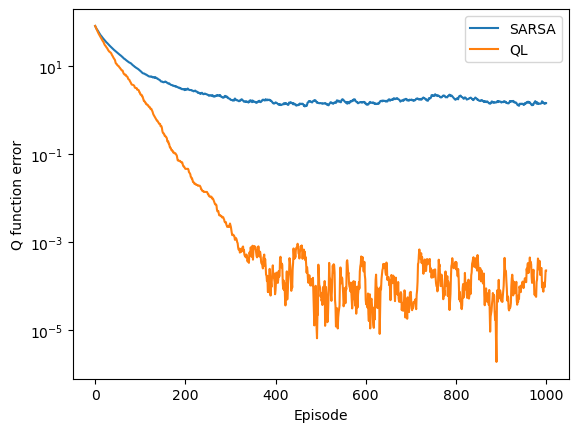

In [4]:
alpha = 0.02  # Update ratio
n_episodes = 1000  # Episodes used to update
ep_length = 50  # Number of steps for each episode

def epsilon_greedy_policy(q, epsilon=0.1):  # Input: q for the given state
  if rng.random(1) < epsilon:
    return rng.choice(np.arange(q.size))  # Return an action uniformly
  else:
    return np.argmax(q)  # Action that maximizes q

# SARSA
print('Obtaining SARSA control...')
q_sarsa = np.zeros((n_episodes + 1, n_states, n_actions))
for e in range(n_episodes):
  state = np.random.choice(np.arange(n_states))  # Random init state
  q = q_sarsa[e, :, :]  # States x action q-value function
  action = epsilon_greedy_policy(q[state])
  for k in range(ep_length):
    next_state, reward = step(state, action)
    next_action = epsilon_greedy_policy(q[next_state])
    q[state, action] = q[state, action] + alpha * (reward + gamma * q[next_state, next_action] - q[state, action])  # SARSA update
    state = next_state
    action = next_action
  q_sarsa[e + 1] = q  # Updated Q

pi_sarsa = np.zeros((n_states, n_states * n_actions))
for s in range(n_states):  # SARSA policy
  pi_sarsa[s, s * n_actions + np.argmax(q_sarsa[-1, s, :])] = 1

# Q-Learning
print('Obtaining Q-Learning control...')
q_ql = np.zeros((n_episodes + 1, n_states, n_actions))
for e in range(n_episodes):
  state = np.random.choice(np.arange(n_states))  # Random init state
  q = q_ql[e, :, :]  # States x action q-value function
  for k in range(ep_length):
    action = epsilon_greedy_policy(q[state])
    next_state, reward = step(state, action)
    q[state, action] = q[state, action] + alpha * (reward + gamma * np.amax(q[next_state, :]) - q[state, action])  # Q-learning update
    state = next_state
  q_ql [e + 1] = q

pi_ql = np.zeros((n_states, n_states * n_actions))
for s in range(n_states):  # Q-learning policy
  pi_ql[s, s * n_actions + np.argmax(q_ql[-1, s, :])] = 1

print('Optimal policy (theory)')
print(tabulate(pi, tablefmt="fancy_grid"))
print('Optimal policy (SARSA)')
print(tabulate(pi_sarsa, tablefmt="fancy_grid"))
print('Optimal policy (Q-learning)')
print(tabulate(pi_ql, tablefmt="fancy_grid"))

values = []
values.append(['Exact'])
values[-1].extend(list(q_pi_exact))
values.append(['SARSA'])
values[-1].extend(list(q_sarsa[-1].flatten()))
values.append(['Q-learning'])
values[-1].extend(list(q_ql[-1].flatten()))
print('Optimal state-action value function found')
print(tabulate(values, tablefmt="fancy_grid", headers=['Method', 'q(x,u)', 'q(x,m)', 'q(y,u)', 'q(y,m)']))

plt.semilogy(np.sum(np.square(q_sarsa - np.repeat(q_pi_exact.reshape([1, n_states, n_actions]), n_episodes + 1, axis=0)), axis=(1,2)), label='SARSA')
plt.semilogy(np.sum(np.square(q_ql - np.repeat(q_pi_exact.reshape([1, n_states, n_actions]), n_episodes + 1, axis=0)), axis=(1,2)), label='QL')
plt.legend(loc='best')
plt.xlabel('Episode')
plt.ylabel('Q function error')
plt.show()